In [1]:
import math
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Conv1D, Lambda, SimpleRNN
import matplotlib.pyplot as plt 
import pandas_datareader as web
plt.style.use('fivethirtyeight')

In [2]:
from os.path import dirname
dirPath = dirname(dirname(os.getcwd()))+"\codec\TotalCleanedTest.csv"
dirPath
df = pd.read_csv(dirPath)
df['ent_regis'] = df['ent_regis'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_resid'] = df['ent_resid'].apply(lambda x: '{0:0>2}'.format(x))
df['ent_ocurr'] = df['ent_ocurr'].apply(lambda x: '{0:0>2}'.format(x))
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'])
df.head()

KeyError: "['Unnamed: 0.1.1'] not found in axis"

In [3]:
def getTimeSeries(state):
    dff = df.loc[(df['ent_regis'] == state)]
    series = dff['date_ocurr'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    series = series.sort_values(by=['unique_values'])
    series.reset_index(inplace=True)
    series = series.drop(columns=['index'])
    return series

In [15]:
series = getTimeSeries('01')
series.iloc[-1,0]

'2019-12-25'

In [16]:
series.iloc[0,0]

'2010-01-01'

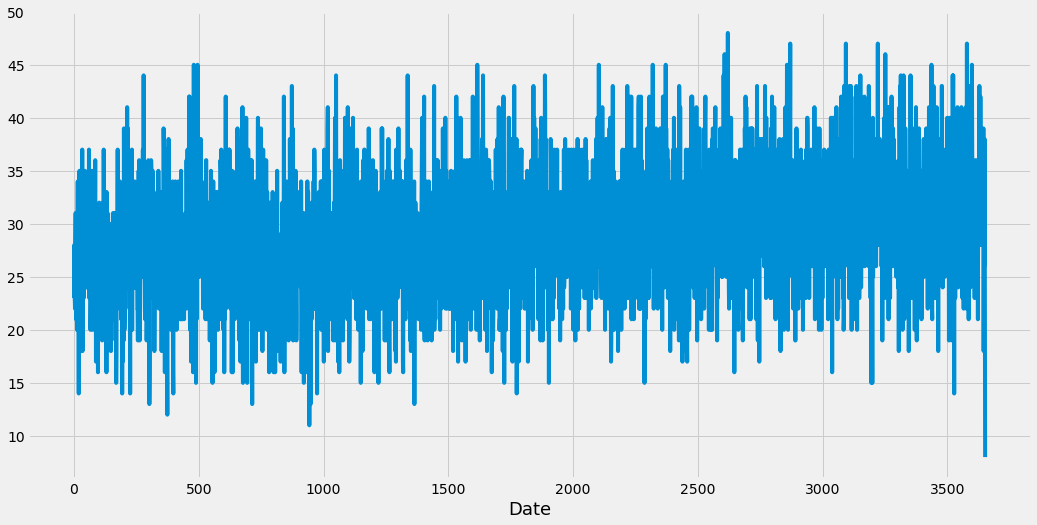

In [5]:
plt.figure(figsize=(16,8))
plt.plot(series['counts'])
plt.xlabel('Date',fontsize=18)
plt.show()

In [6]:
data = series.filter(['counts'])
dataset = data.values
dataset = dataset.astype('float32')

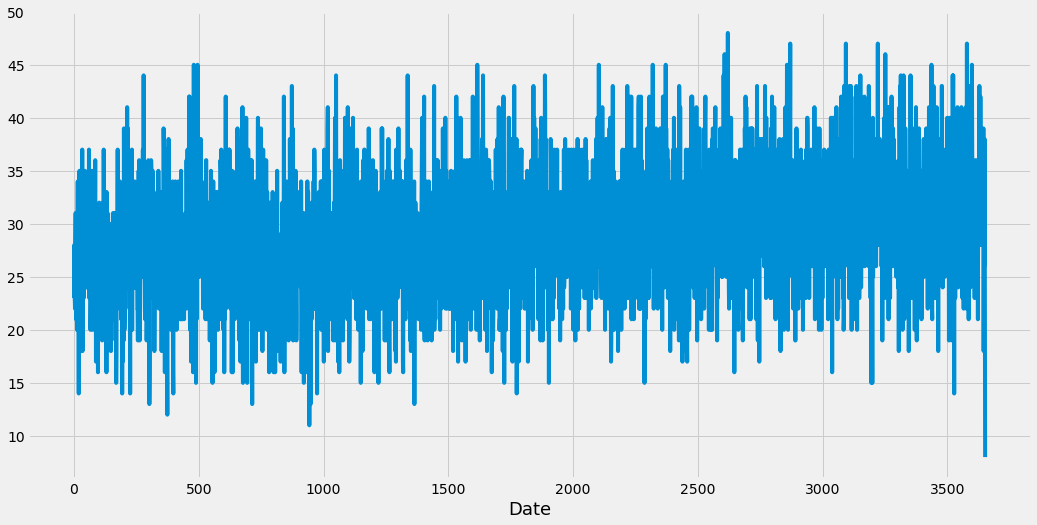

In [7]:
plt.figure(figsize=(16,8))
plt.plot(dataset)
plt.xlabel('Date',fontsize=18)
plt.show()

# Smoothing

## exponential

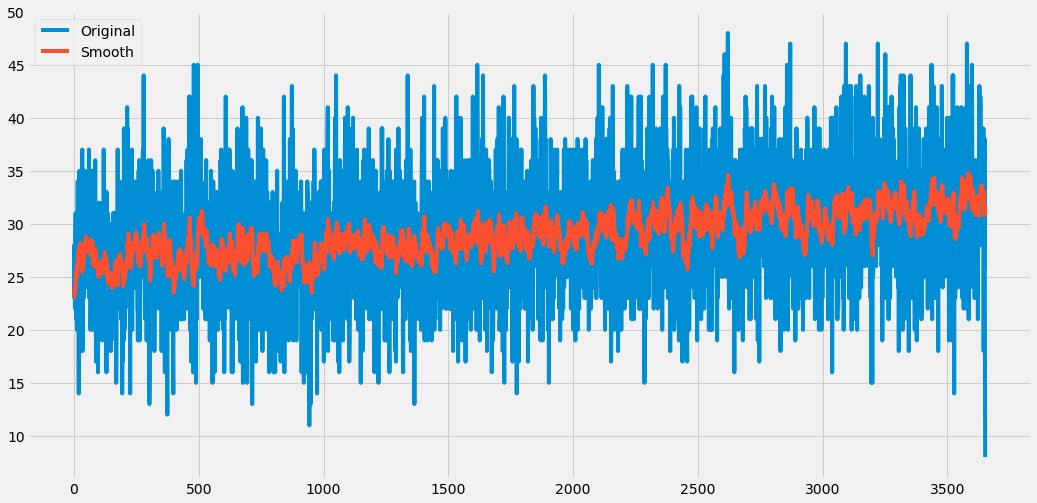

In [8]:
##smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.figure(figsize=(16,8))
plt.plot(dataset)
fit1 = SimpleExpSmoothing(dataset).fit(smoothing_level=0.1,optimized=False)
plt.plot(fit1.fittedvalues)
plt.legend(['Original', 'Smooth'])

In [9]:
#calculating error
series['alfa 0.1'] = fit1.fittedvalues
series['error alpha 0.1'] = series['counts']-series['alfa 0.1']
series['mae error alpha 0.1'] = pow(series['error alpha 0.1'],2)
series.head()

,unique_values,counts,alfa 0.1,error alpha 0.1,mae error alpha 0.1
0,2010-01-01,23,23.000,0.000,0.000000
1,2010-01-02,28,23.000,5.000,25.000000
2,2010-01-03,28,23.500,4.500,20.250001
3,2010-01-04,23,23.950,-0.950,0.902500
4,2010-01-05,22,23.855,-1.855,3.441024


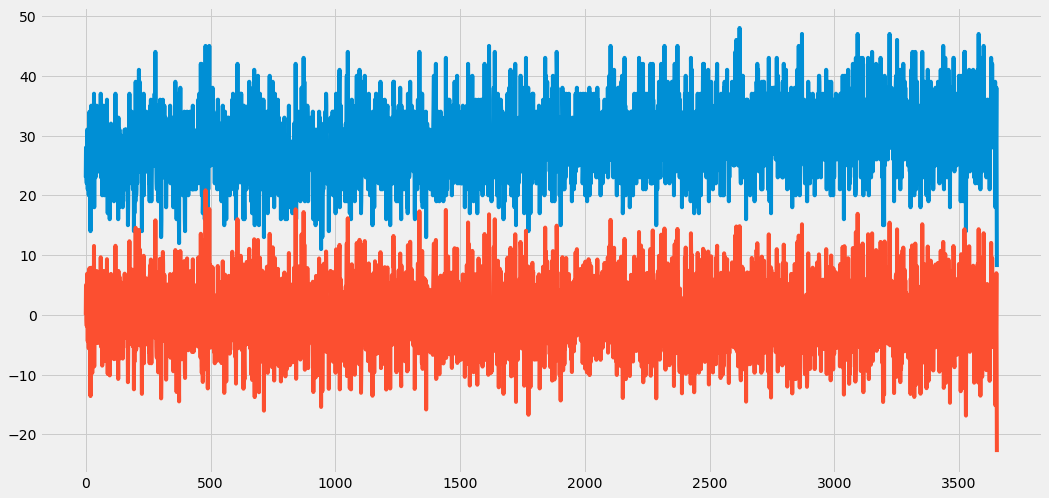

In [10]:
plt.figure(figsize=(16,8))
plt.plot(dataset)
plt.plot(series['error alpha 0.1'])

## Hodrick-Prescott

In [11]:
import statsmodels.api as sm
cycle, trend = sm.tsa.filters.hpfilter(series.counts, 1600)
gdp_decomp = series[['counts']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

gdp_decomp.head()

<ipython-input-11-175aab50a05f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_decomp["cycle"] = cycle
<ipython-input-11-175aab50a05f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_decomp["trend"] = trend


,counts,cycle,trend
0,23,-2.887153,25.887153
1,28,1.951557,26.048443
2,28,1.792072,26.207928
3,23,-3.365024,26.365024
4,22,-4.520267,26.520267


In [12]:
gdp_decomp.shape

(3652, 3)

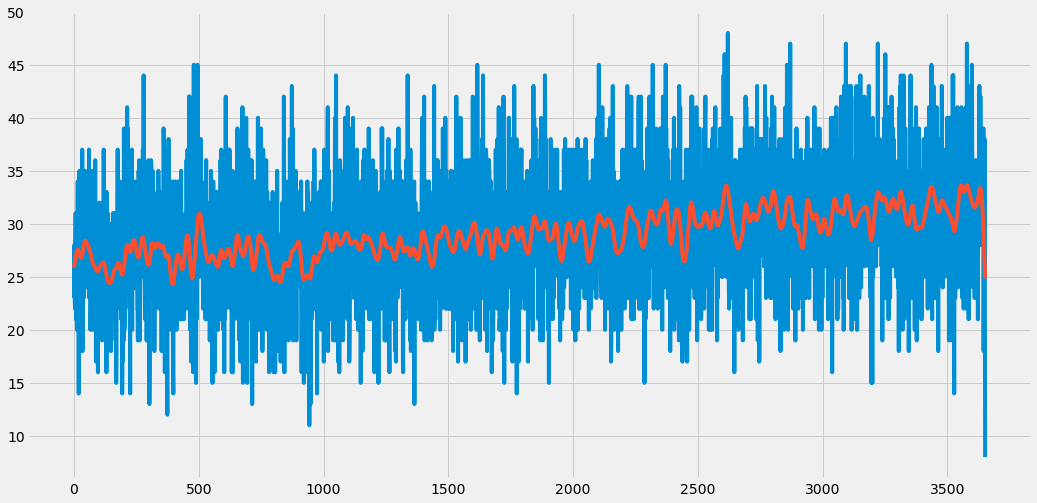

In [13]:
plt.figure(figsize=(16,8))
plt.plot(gdp_decomp[["counts", "trend"]])

## LSTM using HP Filters for smoothing

In [15]:
data = gdp_decomp.filter(['trend'])
dataset = data.values
dataset

array([[27.96487036],
       [28.09534288],
       [28.22771236],
       ...,
       [26.32151607],
       [25.59147501],
       [24.85090214]])

In [16]:
training_data_len = math.ceil(len(dataset)*.875)
training_data_len

2557

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
train_data = scaled_data[0:training_data_len,:]
look_backs = 60

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])
    if i<=look_backs+1:
        print(x_train)
        print(y_train)
        print()

[array([0.37857672, 0.39280887, 0.40724794, 0.42202619, 0.43726032,
       0.4524969 , 0.46677097, 0.4792101 , 0.48916187, 0.49673146,
       0.50141189, 0.50317019, 0.50230802, 0.49939249, 0.4949839 ,
       0.48943311, 0.48315698, 0.47650547, 0.46983375, 0.46289276,
       0.45524246, 0.44714244, 0.43880677, 0.43047724, 0.42263308,
       0.41572351, 0.41024075, 0.40597446, 0.40276506, 0.4000974 ,
       0.39805714, 0.39658258, 0.39546586, 0.39469479, 0.39377181,
       0.39205529, 0.38916925, 0.38466346, 0.3780835 , 0.36938257,
       0.35878929, 0.34626772, 0.33234208, 0.31762737, 0.30249717,
       0.28682012, 0.27085572, 0.25471866, 0.23872971, 0.22322127,
       0.20882008, 0.19584329, 0.18464838, 0.17536857, 0.16744254,
       0.16023386, 0.1531041 , 0.14582638, 0.13804446, 0.1296181 ])]
[0.12042346540774052]

[array([0.37857672, 0.39280887, 0.40724794, 0.42202619, 0.43726032,
       0.4524969 , 0.46677097, 0.4792101 , 0.48916187, 0.49673146,
       0.50141189, 0.50317019, 0.50

In [19]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2497, 60, 1)

# LSTM

In [20]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation

In [21]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [22]:
history = model.fit(x_train,y_train,batch_size=1,epochs=2)

Epoch 1/2
2497/2497 [==============================] - 58s 21ms/step - loss: 0.0160 - mae: 0.0787
Epoch 2/2
2497/2497 [==============================] - 53s 21ms/step - loss: 3.6348e-04 - mae: 0.0150


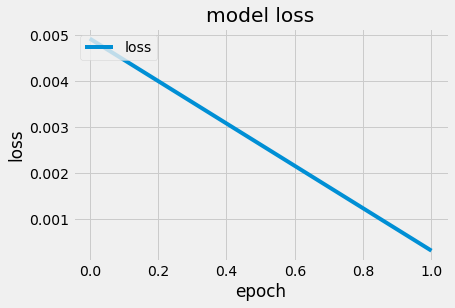

In [23]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## Predictions

In [24]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])

In [25]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [34]:
x_test.shape

(365, 60, 1)

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [26]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.07375368831019571

In [27]:
train = gdp_decomp[:training_data_len]
valid = gdp_decomp[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-27-0fea0317271c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,counts,cycle,trend,Predictions
2555,7,-0.257401,7.257401,7.102116
2556,3,-4.287728,7.287728,7.119360
2557,7,-0.330093,7.330093,7.161846
2558,10,2.618351,7.381649,7.229878
2559,2,-5.439342,7.439342,7.318622
...,...,...,...,...
2915,4,0.423050,3.576950,4.123580
2916,4,0.796271,3.203729,3.874494
2917,1,-1.825564,2.825564,3.628893
2918,1,-1.445167,2.445167,3.387720


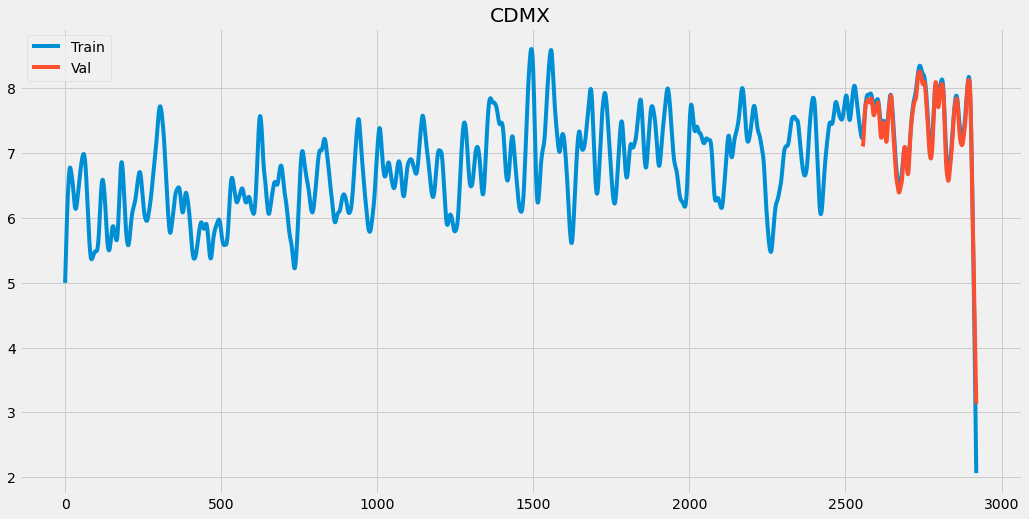

In [28]:
fig1 = plt.figure(figsize=(16,8))
plt.title("CDMX")
plt.plot(gdp_decomp[["trend"]])
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [29]:
filename = r'\bajaSur.png'
dirPath = dirname(os.getcwd())+"\ResultsLSTM" + filename
fig1.savefig(dirPath)

## Predict 01-01-2020

In [30]:
df1 = gdp_decomp.filter(['trend'])
#get the last 60 observations
last_60_days = df1[-60:].values
#scale the data 
last_60_days_scaled = scaler.transform(last_60_days)
#empty list
X_test = []
#Append the last 60 days
X_test.append(last_60_days_scaled)
#convert to a numpy array
X_test = np.array(X_test)
#reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled value
pred_val = model.predict(X_test)
#undo the scaling
pred_cases = scaler.inverse_transform(pred_val)
print(pred_cases[0][0])

2.8989484


In [31]:
predictions = []
df1 = gdp_decomp.filter(['trend'])
dff = df1
count = 0
while(1):
    if count == 366:
        break
    else:
        last_60_days = dff[-60:].values
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        #Append the last 60 days
        X_test.append(last_60_days_scaled)
        #convert to a numpy array
        X_test = np.array(X_test)
        #reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled value
        pred_val = model.predict(X_test)
        pred_cases = scaler.inverse_transform(pred_val)
        df1.loc[2922+count+1] = pred_cases[0][0]
        dff = df1
        count = count+1

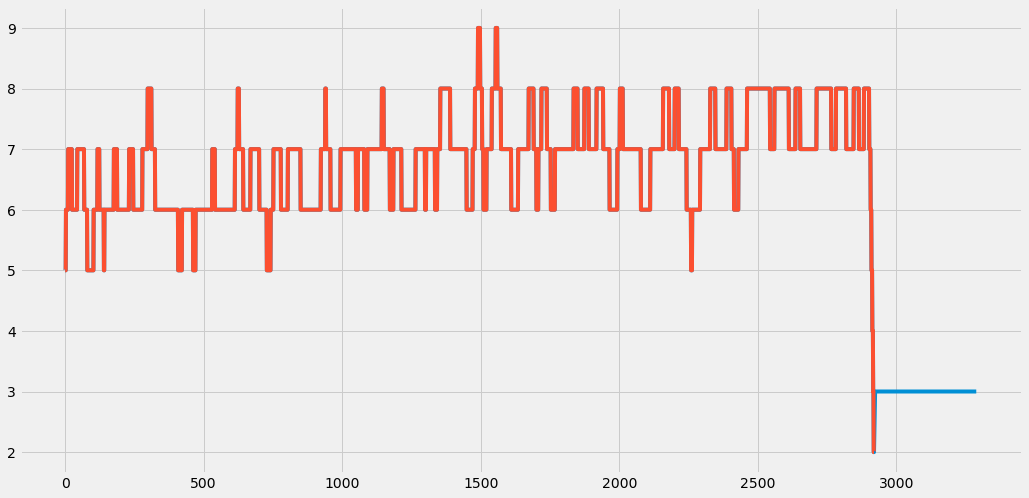

In [32]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df1.round(0))
plt.plot(gdp_decomp[["trend"]].round(0))
plt.show()

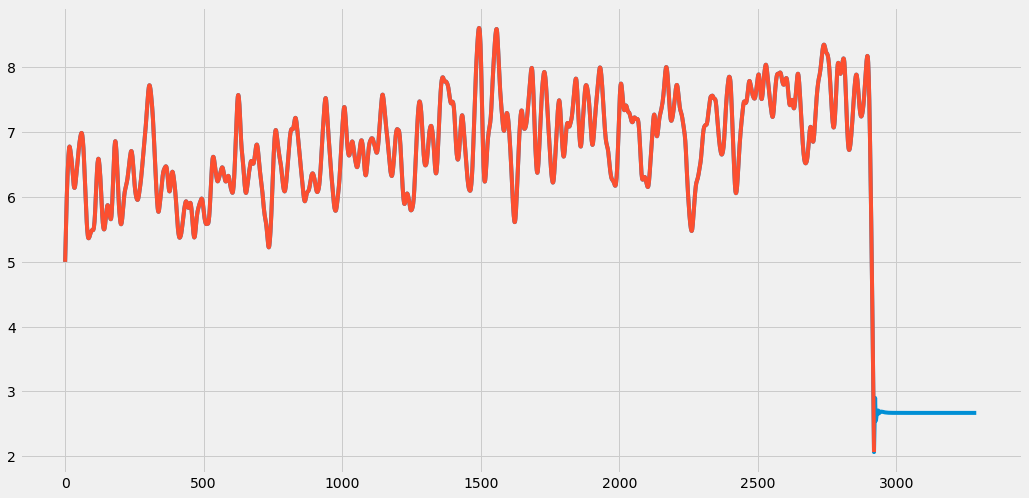

In [33]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df1)
plt.plot(gdp_decomp[["trend"]])
plt.show()

In [316]:
df1.to_csv("2020.csv")

## EXP

In [630]:
series = getTimeSeries('09')
series.iloc[-1,0]

'2019-12-31'

In [631]:
data = series.filter(['counts'])
dataset = data.values
dataset = dataset.astype('float32')

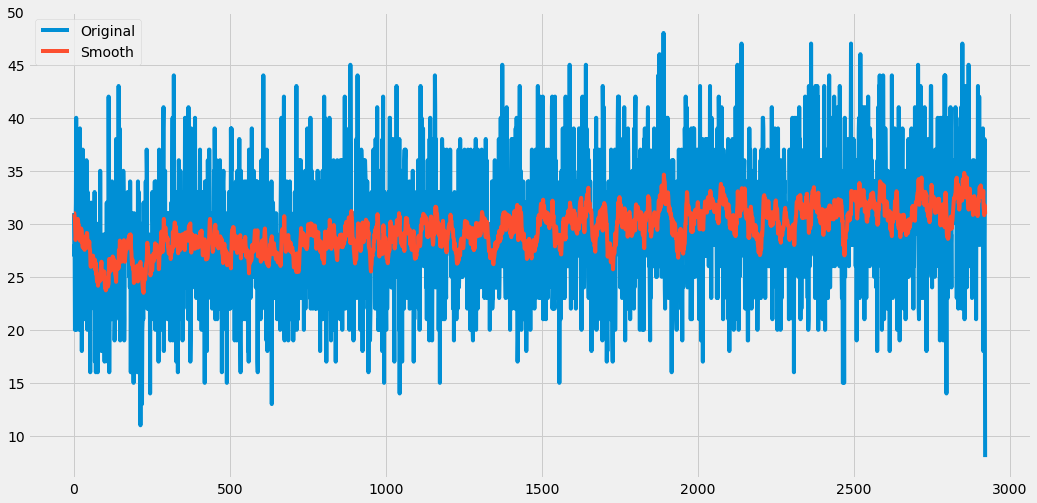

In [632]:
##smoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
plt.figure(figsize=(16,8))
plt.plot(dataset)
fit1 = SimpleExpSmoothing(dataset).fit(smoothing_level=0.1,optimized=False)
plt.plot(fit1.fittedvalues)
plt.legend(['Original', 'Smooth'])

In [633]:
df1 = pd.DataFrame(fit1.fittedvalues, columns= ['Fitted'])
df1.head()

,Fitted
0,31.000
1,31.000
2,30.600
3,30.340
4,29.306


In [634]:
dataset = df1.values

In [635]:
training_data_len = math.ceil(len(dataset)*.875)
training_data_len

2557

In [636]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [637]:
train_data = scaled_data[0:training_data_len,:]
look_backs = 60

x_train = []
y_train = []

for i in range(look_backs, len(train_data)):
    x_train.append(train_data[i-look_backs:i,0])
    y_train.append(train_data[i,0])
    if i<=look_backs+1:
        print(x_train)
        print(y_train)
        print()

[array([0.66385453, 0.66385454, 0.6284874 , 0.60549875, 0.51407468,
       0.44063481, 0.454115  , 0.48393074, 0.5814992 , 0.49247508,
       0.55382197, 0.59135059, 0.61628455, 0.60335799, 0.56519872,
       0.56622252, 0.54946036, 0.54321621, 0.45802039, 0.43439489,
       0.52807515, 0.51512773, 0.51231684, 0.5363124 , 0.52254125,
       0.51898901, 0.41853235, 0.42538101, 0.37849406, 0.46008083,
       0.43624928, 0.41480089, 0.43970627, 0.37370324, 0.35850945,
       0.39788575, 0.38911549, 0.39006403, 0.44396845, 0.47479884,
       0.43181192, 0.49922512, 0.4980045 , 0.45269701, 0.37655311,
       0.42296682, 0.39400487, 0.41214805, 0.40195156, 0.42814187,
       0.37213706, 0.36594167, 0.32499866, 0.22625746, 0.21696645,
       0.21744634, 0.27092895, 0.24832901, 0.272198  , 0.26715473])]
[0.28029934948187973]

[array([0.66385453, 0.66385454, 0.6284874 , 0.60549875, 0.51407468,
       0.44063481, 0.454115  , 0.48393074, 0.5814992 , 0.49247508,
       0.55382197, 0.59135059, 0.61

In [638]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2497, 60, 1)

## LSTM

In [639]:
model = Sequential() #initialize sequential model
model.add(LSTM(64,input_shape=(x_train.shape[1],1), return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32, return_sequences=True)) #LSTM layer with 32 neurons
model.add(LSTM(32)) #LSTM layer with 32 neurons
model.add(Dense(16,activation='relu')) #Dense layer with 16 neurons
model.add(Dense(8,activation='relu')) #Dense layer with 8 neurons
model.add(Dense(1,activation='linear')) #Dense output layer with 1 neuron, linear activation

In [640]:
model.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [641]:
history = model.fit(x_train,y_train,batch_size=1,epochs=5)

Epoch 1/5
2497/2497 [==============================] - 66s 24ms/step - loss: 0.0180 - mae: 0.0981
Epoch 2/5
2497/2497 [==============================] - 66s 27ms/step - loss: 0.0036 - mae: 0.0466
Epoch 3/5
2497/2497 [==============================] - 60s 24ms/step - loss: 0.0034 - mae: 0.0466
Epoch 4/5
2497/2497 [==============================] - 62s 25ms/step - loss: 0.0031 - mae: 0.0446
Epoch 5/5
2497/2497 [==============================] - 60s 24ms/step - loss: 0.0030 - mae: 0.0435


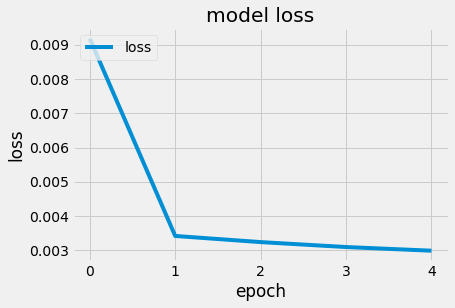

In [642]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## predictions

In [643]:
test_data = scaled_data[training_data_len - look_backs: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(look_backs, len(test_data)):
    x_test.append(test_data[i-look_backs:i, 0])

In [644]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [645]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [646]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.2483129962062258

In [647]:
train = df1[:training_data_len]
valid = df1[training_data_len:]
valid['Predictions'] = predictions
valid

<ipython-input-647-f043aaa5b21f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Fitted,Predictions
2557,32.264556,32.774723
2558,32.338101,32.543808
2559,32.704291,32.569279
2560,32.833862,32.868855
2561,32.950476,33.010979
...,...,...
2917,31.348878,32.086990
2918,30.813991,31.671352
2919,31.032592,31.164831
2920,31.729332,31.308735


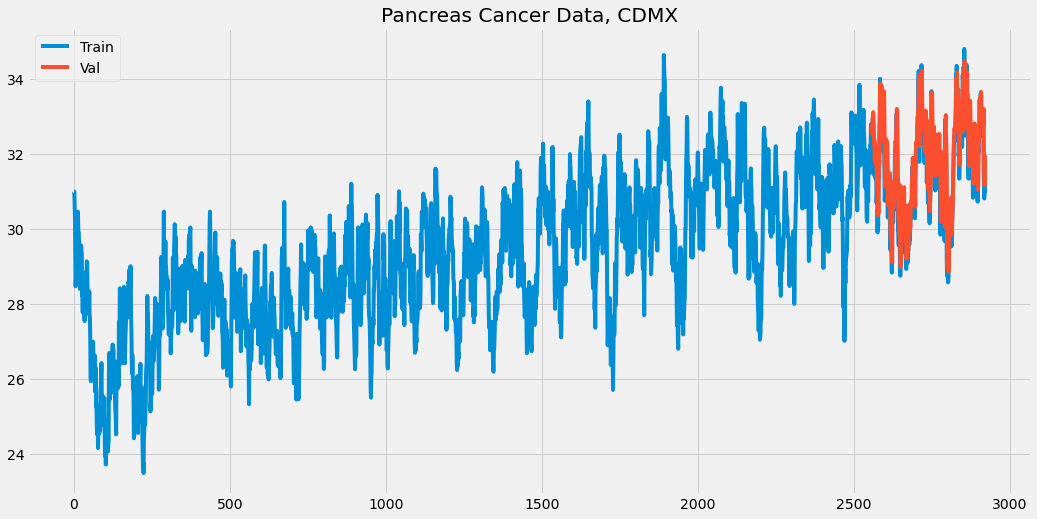

In [648]:
fig1 = plt.figure(figsize=(16,8))
plt.title("Pancreas Cancer Data, CDMX")
plt.plot(df1)
plt.plot(valid["Predictions"])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

## 2020

In [649]:
df1 = series.filter(['counts'])
#get the last 60 observations
last_60_days = df1[-60:].values
#scale the data 
last_60_days_scaled = scaler.transform(last_60_days)
#empty list
X_test = []
#Append the last 60 days
X_test.append(last_60_days_scaled)
#convert to a numpy array
X_test = np.array(X_test)
#reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled value
pred_val = model.predict(X_test)
#undo the scaling
pred_cases = scaler.inverse_transform(pred_val)
print(pred_cases[0][0])

24.636414


In [650]:
df1.loc[2933] = pred_cases[0][0]
df1.shape

(2923, 1)

In [654]:
count = 0
df1 = pd.DataFrame(fit1.fittedvalues, columns= ['Fitted'])
dff = df1
while(1):
    if count == 365:
        break
    else:
        last_60_days = dff[-60:].values
        last_60_days_scaled = scaler.transform(last_60_days)
        X_test = []
        #Append the last 60 days
        X_test.append(last_60_days_scaled)
        #convert to a numpy array
        X_test = np.array(X_test)
        #reshape the data
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        #Get the predicted scaled value
        pred_val = model.predict(X_test)
        pred_cases = scaler.inverse_transform(pred_val)
        df1.loc[2922+count+1] = pred_cases[0][0]
        dff = df1
        count = count+1

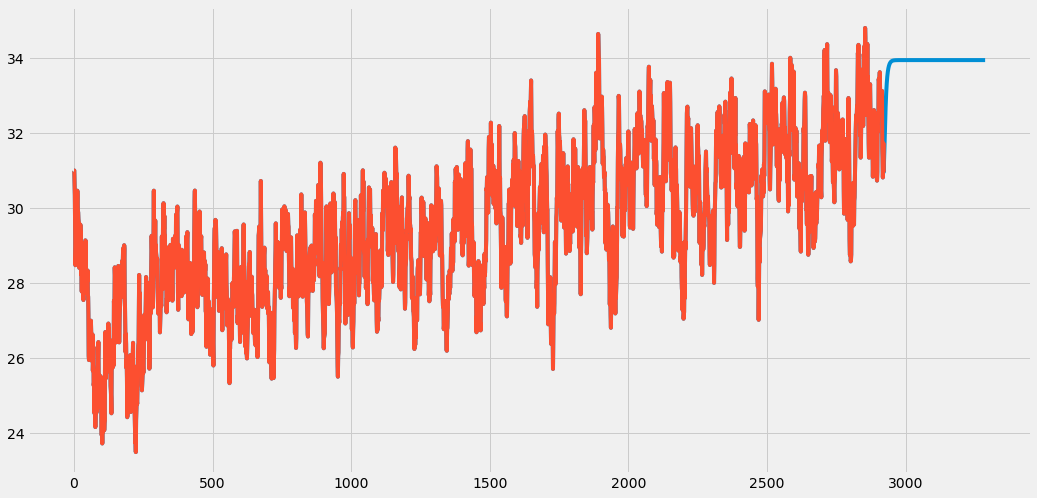

In [655]:
fig1 = plt.figure(figsize=(16,8))
plt.plot(df1)
plt.plot(pd.DataFrame(fit1.fittedvalues, columns= ['Fitted']))
plt.show()